In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

In [2]:
#%pip install git+https://github.com/erikavaris/tokenizer.git

In [3]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from tokenizer import tokenizer as tk


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Función para tokenizar los comments
def tokenizer(text):
    rt = tk.RedditTokenizer()
    return rt.tokenize(text)

### Loading comments

In [7]:
comments_df = pd.read_csv('SuicidiosProyecto_clean.csv', sep = ',', names = ['id','text','class'], index_col='id',header = 1)




In [8]:
comments_df.shape

(195682, 2)

In [9]:
comments_df.sample(5)

,text,class
id,,
162855,please help mei have a friend who is trying to help stop someone from self harming committing suicide and we dont know how to get through to him and help him to stop,suicide
54249,no rest for the wickeddoes anyone else have serious trouble getting out of bed the only thing i seem to look forward too everyday is when i get to go to sleep it seems like im just existing through my boring day so i can escape to my dreams at night i ve had days off where i just lay in bed with my eyes closed wishing i could just escape this reality has anyone else even if death just leads to an emoty void i cant help but wanting to end it just so i dont have to wake up again i guess i just need to make a plan already and stop procrastinating the inevitable,suicide
280831,i m just plain losti don t know why i can t do it i ve gone to counseling of the bat i struggle with my identity i feel homeless and lost not accepted anywhere raised on my parents second language struggled to make close friends and keep them struggled to get into uni struggled to maintain the sports in good at yet i m wondering why it s even worth it just to have a good life what is a good life what does it all mean once you for it all goes away poof like that meaningless so why don t i leave,suicide
220222,i wanna kill myself to escape my shitty life that im livingi cant keep doing this,suicide
199378,im cold and northern of my hoodies are clean sad time doin your mom doin doin your mom,non-suicide


In [10]:
comments_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562898
suicide        0.437102
Name: class, dtype: float64

### Filtrando los comments que aún no han sido etiquetados

In [11]:
comments_labeled_df = comments_df.loc[comments_df['class'].notnull()]

In [12]:
# comments a ser usados para entrenar y evaluar el modelo
comments_labeled_df.shape

(195682, 2)

In [13]:
# comments descartados debido a que no se encuentran etiquetados
comments_df.loc[comments_df['class'].isnull()].shape

(0, 2)

In [14]:
# Scenario 1: Treating neutral as suicide classes
#comments_labeled_df['class'] = comments_labeled_df['class'].replace({'neutral': 'suicide'})

# Scenario 2: Working only with suicide and non-suicide classes
# Removing neutral class
comments_labeled_df = comments_labeled_df.loc[comments_labeled_df['class'].isin(['suicide', 'non-suicide'])]

# Scenario 3: Working with all classes

In [15]:

comments_labeled_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562898
suicide        0.437102
Name: class, dtype: float64

### Diviendo los comments etiquetados en los conjuntos de entrenamiento y prueba

In [16]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(comments_labeled_df['text'], comments_labeled_df['class'], test_size = 0.35, stratify = comments_labeled_df['class'], random_state = 1)

In [17]:
X_train.shape

(127193,)

In [18]:
pd.Series(y_train).value_counts(normalize = True)

non-suicide    0.5629
suicide        0.4371
Name: class, dtype: float64

In [19]:
X_test.shape

(68489,)

In [20]:
pd.Series(y_test).value_counts(normalize = True)

non-suicide    0.562893
suicide        0.437107
Name: class, dtype: float64

### Vectorizando los comments

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [21]:
X_train.head()

id
322468    last person to care dropped mei was just told by my last real friend to not call or text or have anything to fo with him because he was tired of my depression and when i could act normal then he would talk to me again i don t know what to do anymore
331765                                                                                                                      so guys i told my crush i liked her update she hasn t said if she likes me back but i m hopeful because she keeps dropping subtle hints
281797          carbon monoxidejust curious here but i spent a total of hours with a tarp over the exhaust of my car while i slept to try to end it but i still woke up fine curious as how that happens i figured that long was way more then enough to do the job
35826                                          death won t stop be appealing to mei still cannot get over death having more appeal to me than life nothing is good enough here none of it is enough at least in death i w

In [22]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [23]:
X_tfidf = tfidf.fit_transform(X_train.values.astype('U'))

In [24]:
len(tfidf.vocabulary_)

107342

### Entrenamiento de un modelo lr


In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr_model = LogisticRegression(class_weight = "balanced")

In [27]:
lr_model.fit(X_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [28]:
y_train_lr_predict = lr_model.predict(X_tfidf)

In [29]:
X_test_tfidf = tfidf.transform(X_test.values.astype('U'))

In [30]:
type(X_tfidf)

scipy.sparse.csr.csr_matrix

In [31]:
y_test_lr_predict = lr_model.predict(X_test_tfidf)

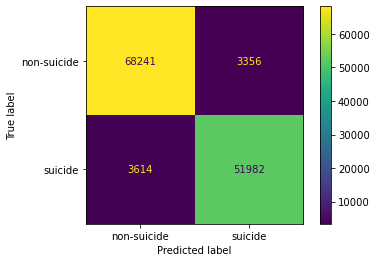

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_lr_predict)

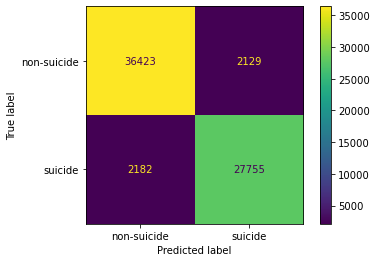

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_lr_predict)

In [34]:
if len(lr_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_lr_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_lr_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_lr_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_lr_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_lr_predict, average = None))
    print('F1:', f1_score(y_train, y_train_lr_predict, average = None))

Precision: 0.9393545122700495
Recall: 0.9349953234045615
F1: 0.9371698487388899


In [35]:
if len(lr_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_lr_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_lr_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_lr_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_lr_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_lr_predict, average = None))
    print('F1:', f1_score(y_test, y_test_lr_predict, average = None))

Precision: 0.9287578637397939
Recall: 0.9271136052376657
F1: 0.9279350061015362


### Análisis del error

In [36]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_lr_predict) ]
, axis = 1).rename(columns = { 'class': 'actual', 0: 'predicted' })

error_df.drop('id', inplace = True, axis = 1)

In [37]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(4311, 3)

In [38]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

text  \
41369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   